<a href="https://colab.research.google.com/github/thhtruc/NeuralNetwork/blob/main/MNIST_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The process will broken down into the following steps:
1. loading and visualize the data
2. define a neural network
3. train model
4. evaluate the performance of trained model on test dataset

In [15]:
"""Train an MLP to classify images from the MNIST database."""
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

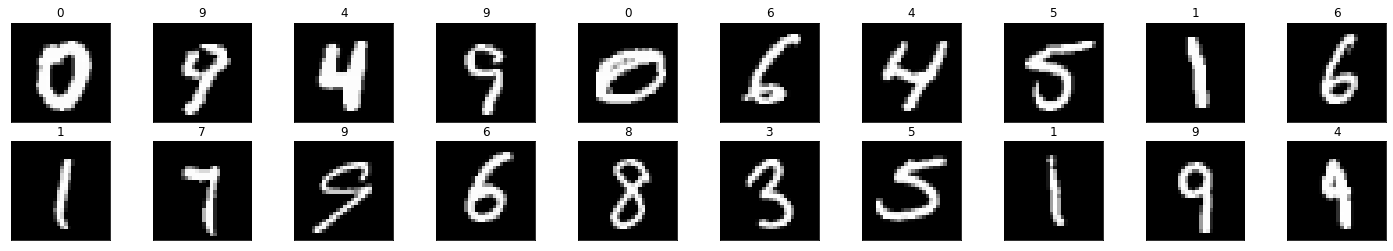

In [16]:
# number of subprocesses to use for data loading
num_workers = 0
batch_size = 20
valid_size = 0.2

# convert data to torch.FloatTensor
transforms = transforms.ToTensor()
train_data = datasets.MNIST(
    root="train_data_MNIST", train=True, download=True, transform=transforms
)
test_data = datasets.MNIST(
    root="test_data_MNIST", train=False, download=True, transform=transforms
)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# visualize a batch of training data
import matplotlib.pyplot as plt
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()


fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    ax.set_title(str(labels[idx].item()))
    img = np.squeeze(images[1])
plt.show()

In [17]:
class MLP(nn.Module):
    """define the MLP."""
    def __init__(self, hidden_layers, dropout=0.5):
        super(MLP, self).__init__()
        hidden_1 = hidden_layers[0]
        hidden_2 = hidden_layers[1]
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [18]:
# initialize the NN
model = MLP(hidden_layers=[512, 256])
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [19]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0

    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss = train_loss/len(train_loader)

    model.eval() # prep model for evaluation
    for images, labels in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # update running validation loss 
        valid_loss += loss.item()
    valid_loss = valid_loss/len(valid_loader)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))


Epoch: 1 	Training Loss: 1.082567 	Validation Loss: 0.414769
Epoch: 2 	Training Loss: 0.431877 	Validation Loss: 0.297513
Epoch: 3 	Training Loss: 0.335212 	Validation Loss: 0.246104
Epoch: 4 	Training Loss: 0.279498 	Validation Loss: 0.204308
Epoch: 5 	Training Loss: 0.241452 	Validation Loss: 0.180350
Epoch: 6 	Training Loss: 0.215491 	Validation Loss: 0.161538
Epoch: 7 	Training Loss: 0.192648 	Validation Loss: 0.145850
Epoch: 8 	Training Loss: 0.177542 	Validation Loss: 0.135934
Epoch: 9 	Training Loss: 0.161292 	Validation Loss: 0.122647
Epoch: 10 	Training Loss: 0.149642 	Validation Loss: 0.116539


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.005392

Test Accuracy of     0: 99% (972/980)
Test Accuracy of     1: 98% (1118/1135)
Test Accuracy of     2: 96% (993/1032)
Test Accuracy of     3: 96% (972/1010)
Test Accuracy of     4: 96% (946/982)
Test Accuracy of     5: 95% (852/892)
Test Accuracy of     6: 97% (930/958)
Test Accuracy of     7: 96% (992/1028)
Test Accuracy of     8: 96% (936/974)
Test Accuracy of     9: 94% (958/1009)

Test Accuracy (Overall): 96% (9669/10000)
